## FINAL PROJECT : 
### Prediksi potensi kebakaran hutan.

#### Author : Karimah
---------------------------------------------------------------------------------------------------------

#### Outline :
1. Load Dataset 
2. Data Cleansing
3. Exploratory Analysis & Visualization
4. Training Data to Predict Forest Fire
5. Conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
import seaborn as sns

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

## 1. Load Dataset
Diketahui data lokasi dan histori kondisi hutan sebagai berikut : 

In [2]:
### IMPORT DATA
df = pd.DataFrame(pd.read_csv('./forestfires.csv', sep= ','))
print(df.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [3]:
# jumlah baris dan kolom dataset :
df.shape

(517, 13)

Deskripsi tiap kolom sbb :
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84



## 2. Data Cleansing

Tipe variabel awal :
- Discrete : X, Y, month, day
- Continuous : FFMC, DMC, DC, ISI, temp, RH, wind, rain, area


In [4]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Cek : apakah data tidak ada yang kosong?

In [5]:
all(df.isnull()==False)

True

Selanjutnya akan diakukan penghapusan data duplikat :

In [6]:
#check for duplicate rows
duplicates = int(df.duplicated().sum())
print('Ditemukan %.3f duplikasi pada data.' % duplicates )
if duplicates>0:
    dup = np.where(df.duplicated()==True)
    df = df.drop(dup[0],axis=0)

Ditemukan 4.000 duplikasi pada data.


Karena ditemukan data duplikat, maka sisa dataset kini sebanyak :

In [7]:
df.shape

(513, 13)

Kemudian mengubah kolom yang berisi string (kolom 'month' dan 'day') dengan mapping tiap string ke angka sbb :

- month : 
jan = 1,
feb = 2, 
..., 
dec = 12

- day : 
mon = 1, 
tue = 2, 
..., 
sun = 7

In [8]:
# Coverting the days and months into the integers
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

Deskripsi data :

In [9]:
df.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,4.678363,4.300195,7.485380,4.251462,90.637427,110.989279,549.155166,9.023587,18.887524,44.348928,4.010526,0.021832,12.891598
std,2.320059,1.230925,2.275095,2.075038,5.540920,64.191013,247.724594,4.575543,5.828128,16.358803,1.796613,0.297107,63.892586
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,440.900000,6.400000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.540000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,11.000000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


## 3. EXPLORATORY ANALYSIS

Distribusi tiap atribut sebagai berikut :

1. Plot histogram untuk melihat distribusi tiap kolom :

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

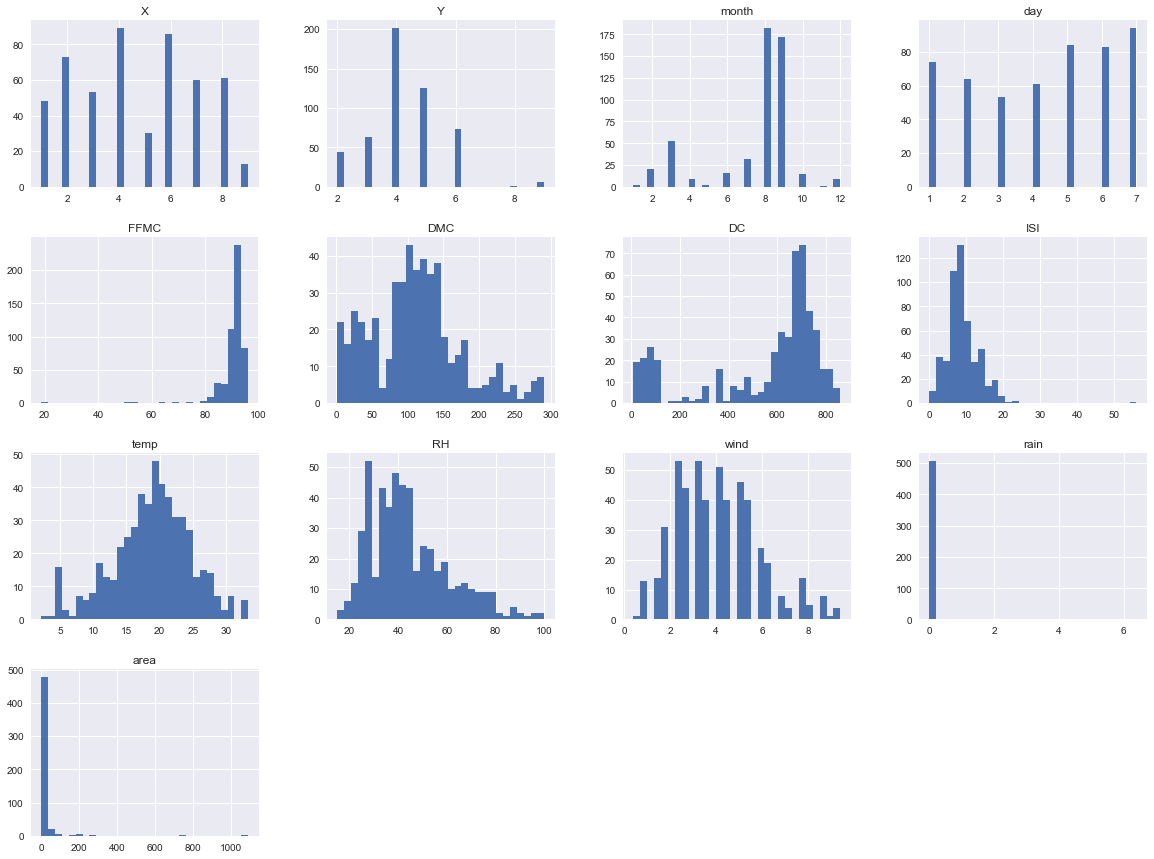

In [10]:
# Libraries and configurations for figure plotting
plt.style.use('seaborn')
df.hist(bins=30, figsize=(20,15)) # plotting the histogram

Tujuan kali ini adalah untuk membuat prediksi potensi klasifikasi terjadinya kebakaran hutan. 
Pada percobaan pertama, kolom continuous "area" yang menyatakan besar area yang terkena kebakaran hutan akan diubah menjadi diskrit dengan 2 kategori sebagai berikut :

0 jika area yang terbakar = 0

1 jika area yang terbakar > 0


Sedangkan di percobaan kedua, kolom yang sama akan diubah menjadi 5 kategori :

1 jika <= 1

2 jika lebih dari 1 dan kurang dari 10

3 jika lebih dari 10 dan kurang dari 100

4 jika lebih dari 100 dan kurang dari 300

5 jika lebih dari 300 dan kurang dari 1,000

6 jika lebih dari 1,000 dan kurang dari 5,000


In [92]:
y = df.area

burned = []
for i in y:
    if i==0:
        burned.append(0)
    else:
        burned.append(1)
df['burned'] = burned


burned_class = []
for i in y:
    i = i*2.47 #convert ha to acre
    if i < 1.0:
        burned_class.append(0)
    elif i < 10.0:
        burned_class.append(1)
    elif i < 100.0:
        burned_class.append(2)
    elif i < 300.0:
        burned_class.append(3)
    else:
        burned_class.append(4)
    
df['burned_class'] = burned_class

Persentase jumlah data tiap kategori sebagai berikut :

[Text(0, 0.5, 'Percent')]

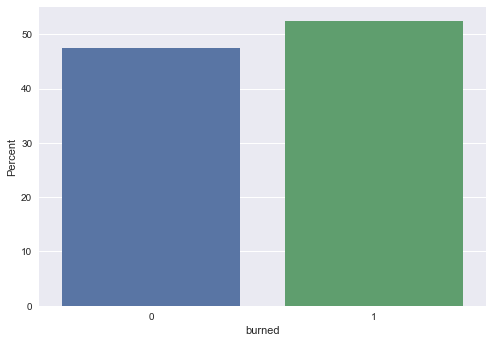

In [93]:
ax = sns.barplot(x='burned', y="burned", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")


Jumlah data sudah cukup balance karena banyak data kedua kategori sekitar 50%

[Text(0, 0.5, 'Percent')]

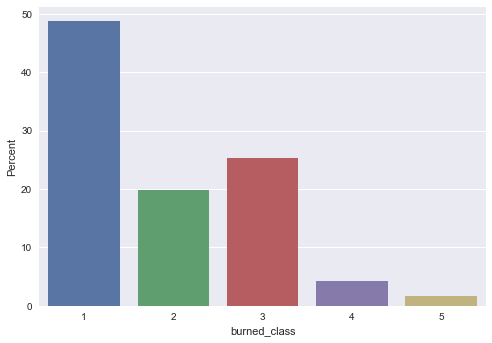

In [13]:
ax = sns.barplot(x='burned_class', y="burned_class", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

Selanjutnya, akan dilihat korelasi linier antar fitur

<AxesSubplot:>

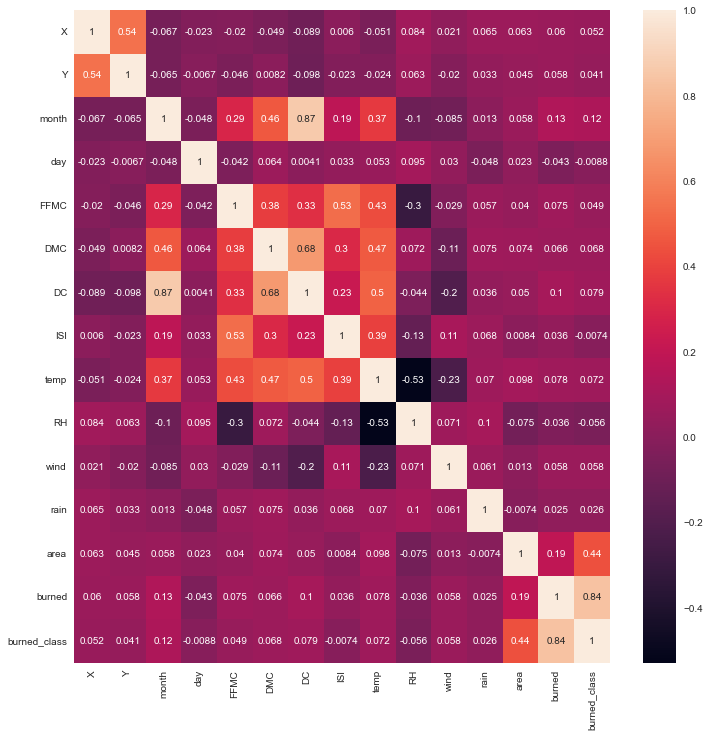

In [14]:
### LINEAR CORRELATION
plt.figure(figsize=(12,12))
linearCorr = df.corr()
sns.heatmap(linearCorr, annot=True)

Terkait persoalan klasifikasi, semua fitur menunjukkan korelasi linier yang mendekati nol terhadap 'burned', berarti terjadi atau tidaknya kebakaran hutan tidak berkolerasi secara linier terhadap apapun. Tapi ada atribut yang saling berkorelasi satu sama lain, yaitu DC dengan month, DMC, dan temp. Maka dapat diwakili salah satu atribut saja yaitu DC. Kemudian ada X dan Y yang juga saling berkorelasi, akan diambil X sebagai wakil keduanya.

In [42]:
#df_pred=df.drop(['DMC','temp', 'month', 'FFMC'], axis=1)
df_pred=df.drop(['DC'], axis=1)

Membuang data target dari df_pred

In [43]:
df_pred=df_pred.drop(['burned','burned_class', 'area'], axis=1)

Plot bar chart untuk melihat perbandingan distribusi tiap kategori diskrit berdasarkan target ('burned')

[Text(17.200000000000003, 0.5, 'Percent')]

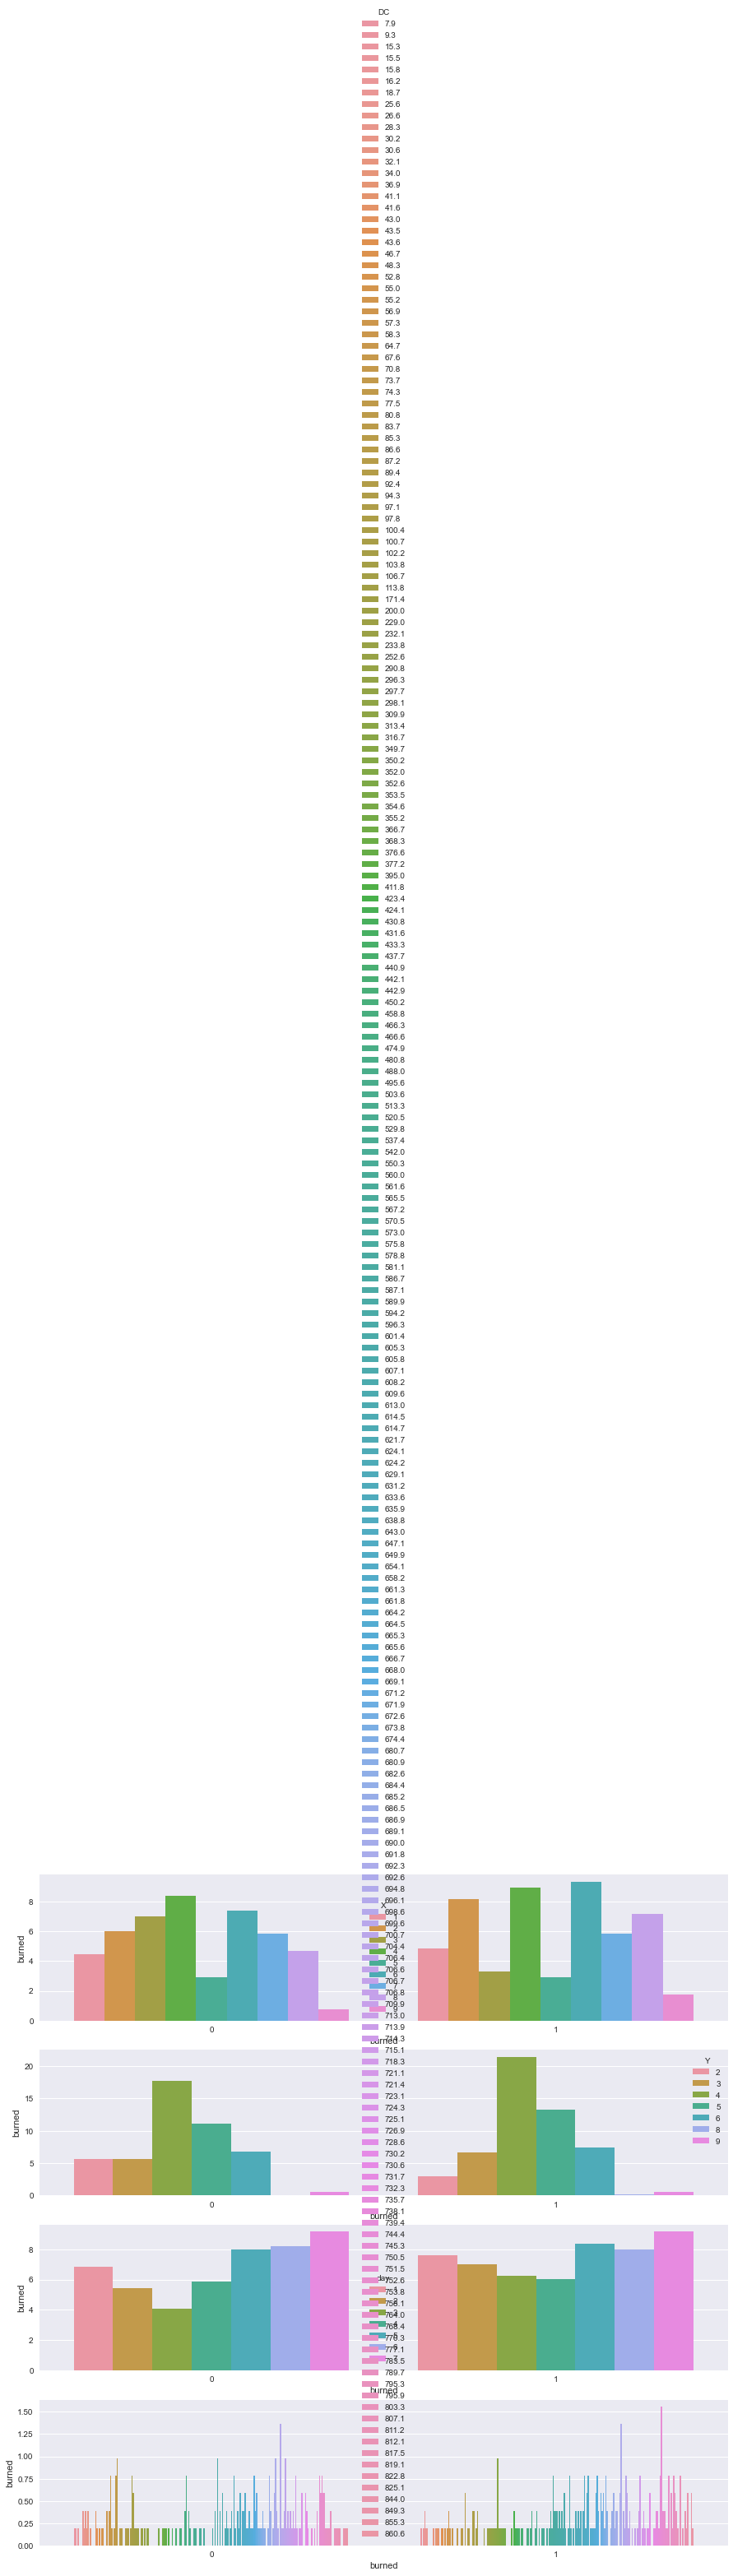

In [17]:
plt.figure(figsize=(15,15))
for i, column in enumerate(df_pred.columns[0:4]):
    plt.subplot(4, 1, i+1); sns.barplot(x='burned', y="burned", data=df, hue=column, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
    

Atribut day menunjukkan distribusi yang mirip, baik di kategori berpotensi/tidak, sehingga atribut ini tidak perlu digunakan sebagai fitur prediktor.

In [44]:
df_pred = df_pred.drop(['day'],axis=1)

In [45]:
df_pred.columns

Index(['X', 'Y', 'month', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')

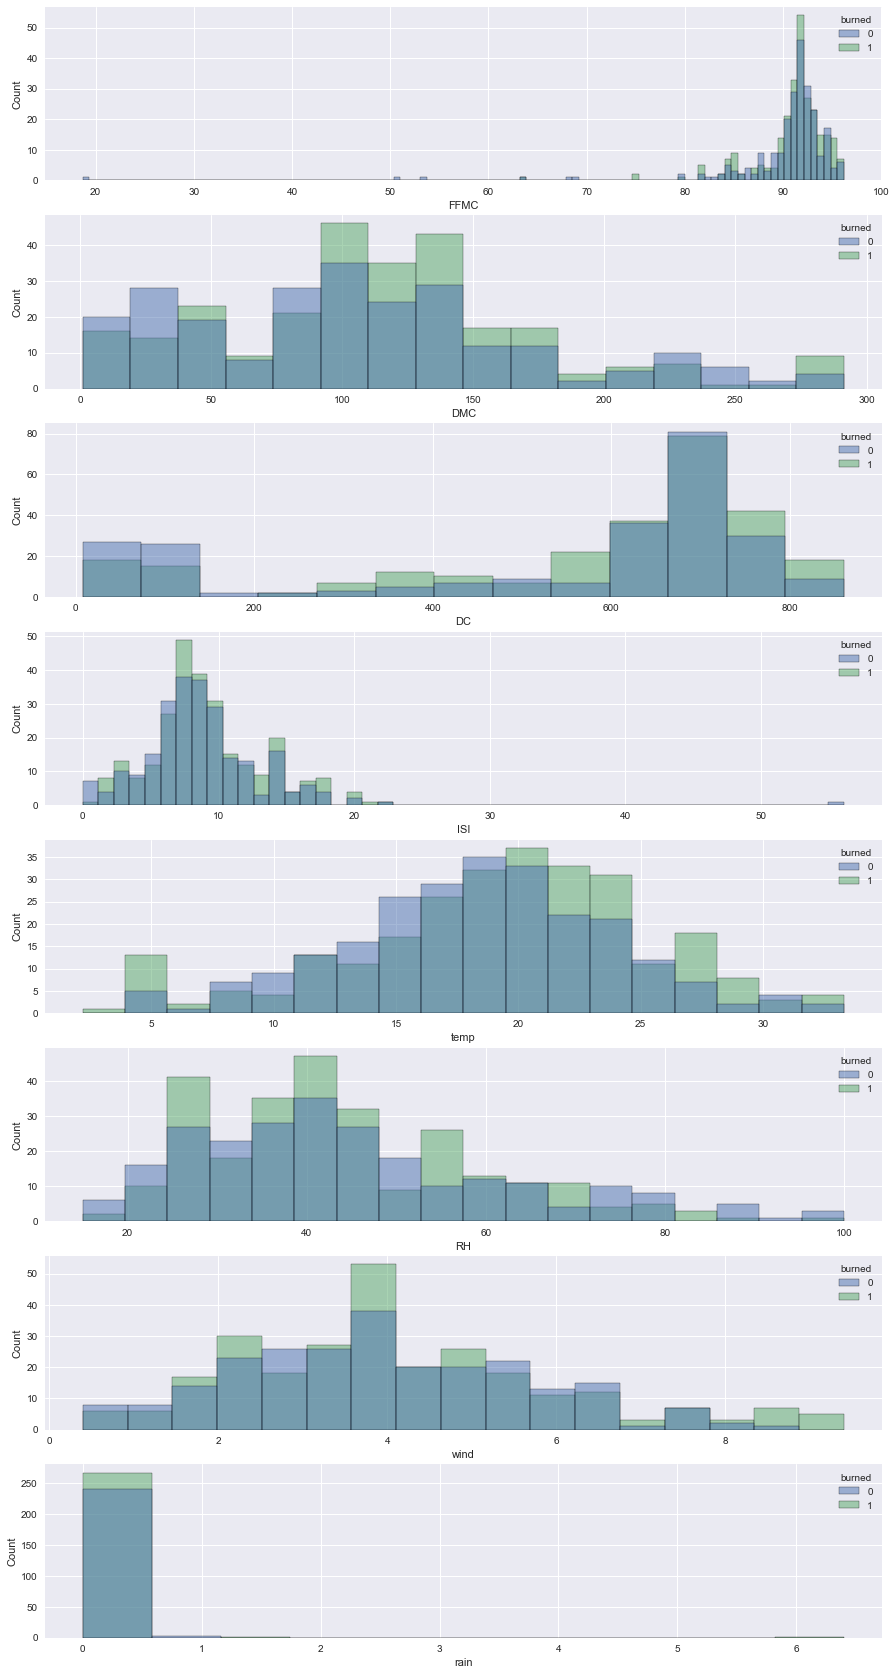

In [46]:
# Plotting the histogram for the RH attribute
from pandas.plotting import scatter_matrix

plt.figure(figsize=(15,30))
for i, column in enumerate(df.columns[4:12]):
    plt.subplot(8, 1, i+1); sns.histplot(data=df, x=column, hue='burned')

#attributes = df.columns[4:12]
#scatter_matrix(df_pred[attributes], figsize=(15,10))

Karena semua atribut diatas memiliki perbedaan untuk tiap kategori burned, maka seluruhnya dapat digunakan.

## 3.TRAINING DATA

#### PREPROCESSING : 

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#1. to categorical target output - y
y1 = to_categorical(df.burned)
y2 = to_categorical(df.burned_class)
#2. Standardizing the data (Feature Scaling) so that all the features are of the same scale
scaler = StandardScaler()
X = scaler.fit_transform(df_pred)

##2. normalize features - X
#X = (df_pred - np.min(df_pred)) / (np.max(df_pred) - np.min(df_pred)).values

#3. split into train and test
X_train, X_test, y_train1, y_test1 = train_test_split(X, y1, test_size=0.3, random_state=1)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.3, random_state=1)

#### ARSITEKTUR :

- Jumlah Hidden Layer : 2 
    - Neuron hidden layer 1 : 50 
    - Neuron hidden layer 2 : 30
- Fungsi Aktivasi : Sigmoid (untuk semua layer)
- Fungsi Optimasi : SGD

In [90]:
# fit a model and plot learning curve function
from tensorflow.keras.callbacks import EarlyStopping
def fit_model(trainX, trainy, validX, validy, n_input, n_output, n_batch, n_epoch, 
              earlystop, layers, neurons, functions, opt, loss_function):
    # define model
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=n_input, activation=functions[0], kernel_initializer='he_uniform'))
    for i in range(1,(layers-2)):
            model.add(Dense(neurons[i], activation=functions[i]))
    model.add(Dense(n_output, activation=functions[layers-1]))

    # compile model
    #opt = SGD(lr=learning_rate, momentum=0.9)
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
    
    # fit model
    history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=n_epoch, callbacks=[earlystop], verbose=0, batch_size=n_batch)
    
    # plot learning curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('batch='+str(n_batch))
    plt.legend()
      
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, valid_acc = model.evaluate(validX, validy, verbose=0)
    diff = train_acc-valid_acc
    print('Batch=%.3f, showed accuracy of Train: %.3f, Valid: %.3f, Difference: %.3f' % (int(n_batch), train_acc, valid_acc, diff))


## Training Model 1
- Batch Size = 4,8,16,32,64,128
- Epoch = 400
- 4 hidden layer

Batch=4.000, showed accuracy of Train: 0.657, Valid: 0.500, Difference: 0.157
Batch=8.000, showed accuracy of Train: 0.638, Valid: 0.494, Difference: 0.144
Batch=16.000, showed accuracy of Train: 0.657, Valid: 0.584, Difference: 0.073
Batch=32.000, showed accuracy of Train: 0.627, Valid: 0.500, Difference: 0.127
Batch=64.000, showed accuracy of Train: 0.616, Valid: 0.526, Difference: 0.090
Batch=128.000, showed accuracy of Train: 0.613, Valid: 0.539, Difference: 0.074


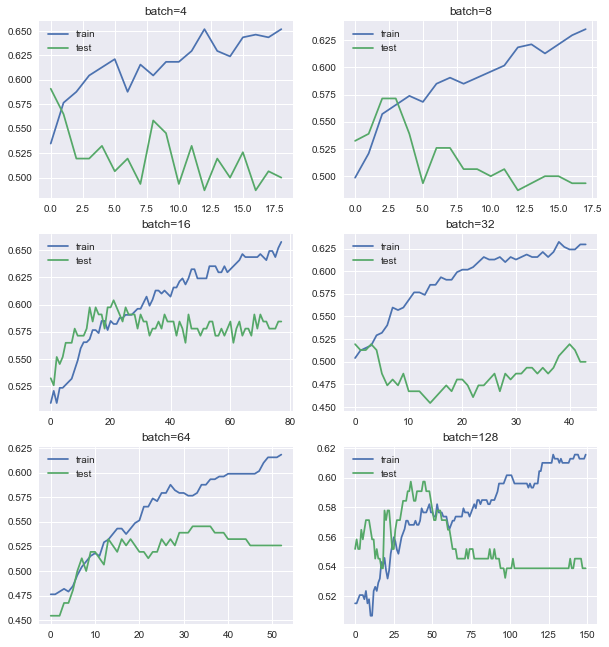

In [91]:
# create learning curves for different batch sizes
n_input = 10
n_output = 2
epoch_iter = 400
layers = 5 #hidden layer+output
neurons = [30,30,30,30] #untuk hidden layer
functions = ['relu','relu','relu','relu','softmax']
opt = SGD(lr=0.001, momentum=0.9)
earlystop_callback = EarlyStopping(monitor='val_loss',patience=10)
loss_function='binary_crossentropy'

batch_sizes = [4,8,16,32,64,128]
plt.figure(figsize=(10, 15))

for i in range(len(batch_sizes)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(X_train, y_train1, X_test, y_test1,  n_input, n_output, batch_sizes[i], epoch_iter, 
              earlystop_callback, layers, neurons, functions, opt, loss_function)
  
# show learning curves
plt.show()

Batch 16 dan 128 menunjukkan hasil yang paling fit dibandingkan batch lain untuk prediksi klasifikasi 2 kategori

Training untuk 5 klasifikasi sbb:

d:\learning space\deeplearning\courseai\courseenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Batch=4.000, showed accuracy of Train: 0.524, Valid: 0.448, Difference: 0.076
Batch=8.000, showed accuracy of Train: 0.543, Valid: 0.448, Difference: 0.095
Batch=16.000, showed accuracy of Train: 0.515, Valid: 0.461, Difference: 0.054
Batch=32.000, showed accuracy of Train: 0.515, Valid: 0.455, Difference: 0.061
Batch=64.000, showed accuracy of Train: 0.526, Valid: 0.461, Difference: 0.065
Batch=128.000, showed accuracy of Train: 0.521, Valid: 0.461, Difference: 0.060


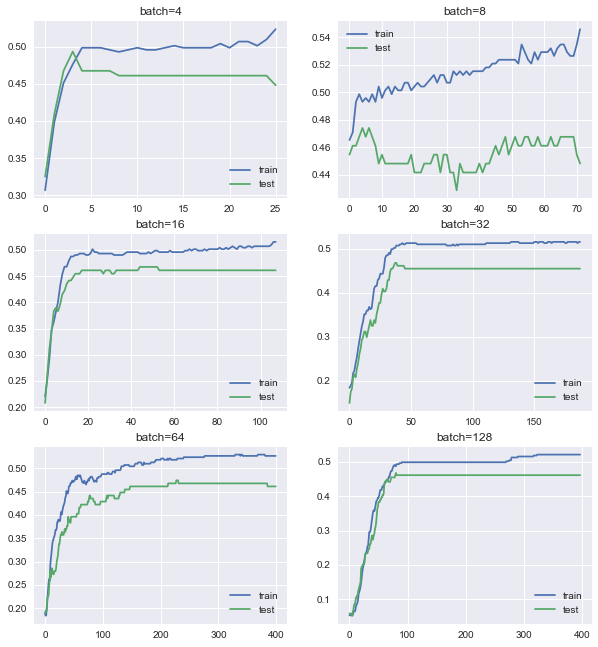

In [97]:
# create learning curves for different batch sizes
n_input = 10
n_output = 5
epoch_iter = 400
layers = 5 #hidden layer+output
neurons = [30,30,30,30] #untuk hidden layer
functions = ['relu','relu','relu','relu','softmax']
opt = SGD(lr=0.001, momentum=0.9)
earlystop_callback = EarlyStopping(monitor='val_loss',patience=10)
loss_function='binary_crossentropy'

batch_sizes = [4,8,16,32,64,128]
plt.figure(figsize=(10, 15))

for i in range(len(batch_sizes)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(X_train, y_train2, X_test, y_test2,  n_input, n_output, batch_sizes[i], epoch_iter, 
              earlystop_callback, layers, neurons, functions, opt, loss_function)
  
# show learning curves
plt.show()

Batch 16 dan 128 pada prediksi klasifikasi 5 kategori juga menunjukkan hasil yang paling fit. Maka untuk selanjutnya akan dicoba untuk menggunakan batch 16 dan 128 menggunakan lebih banyak hidden layer.

## Training Model 2
- Batch Size = 16, 128
- Epoch = 50,100,200,300 
- 9 hidden layer

Batch=16.000, showed accuracy of Train: 0.660, Valid: 0.500, Difference: 0.160
Batch=128.000, showed accuracy of Train: 0.602, Valid: 0.558, Difference: 0.043


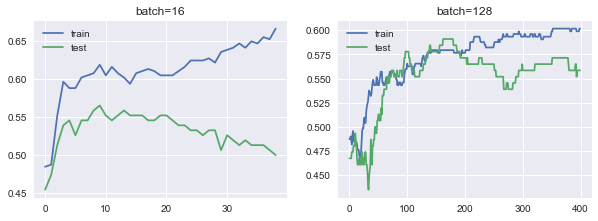

In [101]:
# create learning curves for different batch sizes
n_input = 10
n_output = 2
epoch_iter = 400
layers = 10 #hidden layer+output
neurons = [30,30,30,30,30,30,30,30,30] #untuk hidden layer
functions = ['relu','relu','relu','relu','relu','relu','relu','relu','relu','softmax']
opt = SGD(lr=0.001, momentum=0.9)
earlystop_callback = EarlyStopping(monitor='val_loss',patience=10)
loss_function='binary_crossentropy'

batch_sizes = [16,128]
plt.figure(figsize=(10, 15))

for i in range(len(batch_sizes)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(X_train, y_train1, X_test, y_test1,  n_input, n_output, batch_sizes[i], epoch_iter, 
              earlystop_callback, layers, neurons, functions, opt, loss_function)
  
# show learning curves
plt.show()

Penggunaan hidden layer yang lebih banyak menghasilkan fitness yang lebih baik untuk klasifikasi 2 kategori.

Batch=16.000, showed accuracy of Train: 0.499, Valid: 0.461, Difference: 0.038
Batch=128.000, showed accuracy of Train: 0.499, Valid: 0.461, Difference: 0.038


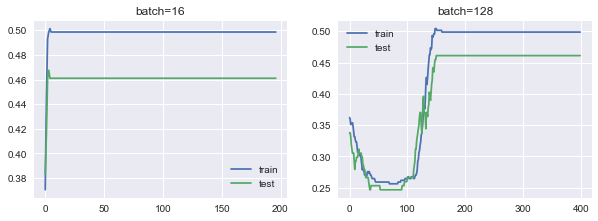

In [103]:
# create learning curves for different batch sizes
n_input = 10
n_output = 5
epoch_iter = 400
layers = 10 #hidden layer+output
neurons = [30,30,30,30,30,30,30,30,30] #untuk hidden layer
functions = ['relu','relu','relu','relu','relu','relu','relu','relu','relu','softmax']
opt = SGD(lr=0.001, momentum=0.9)
earlystop_callback = EarlyStopping(monitor='val_loss',patience=10)
loss_function='binary_crossentropy'

batch_sizes = [16,128]
plt.figure(figsize=(10, 15))

for i in range(len(batch_sizes)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a batch size
    fit_model(X_train, y_train2, X_test, y_test2,  n_input, n_output, batch_sizes[i], epoch_iter, 
              earlystop_callback, layers, neurons, functions, opt, loss_function)
  
# show learning curves
plt.show()

Sebaliknya, penggunaan banyak hidden layer menunjukkan hasil yang undertrained.

--------------------------------- THANK YOU ---------------------------------